<h1> GAN - CNN</h1>
- Nutze CNN statt ANN

Dieses Notebook basiert auf "1_intoduce-GAN-ANN". Diesmal wird ein CNN Netz angewendet, um die Qualität zu steigern.
- Es gibt noch andere Arten von GANs
- Der Output des Generator muss je nach Bedarf als Erstes als Bild Länge x Breite umgeformt werden, wenn der Output ein Vektor ist.

<i>Abb1</i>: Übersicht GAN.

<img src="./data/img/2_gan.PNG" height=500 width=700>

Weitere Inhalte zu GAN:

> GAN Applications: Everything You Need to Know <br>
> https://neptune.ai/blog/generative-adversarial-networks-gan-applications [Letzter Zugriff: 23.07.2024]

Als Erstes werden wir wieder nur eine Klasse nutzen und versuchen mit einem Generator basierend auf CNN ein Bild zu erzeugen. <br>
Dieses Mal ist es ein RGB Bild.

Als Einstieg soll der Generator ein 100*100 Pixelbild eines Apfels herstellen. 

In [59]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import cv2

Hier werden wir die Funktionsweise des Faltungsnetzes umkehren. Zu Beginn geben wir die Dimension des Bildes an, das dann Hochskaliert wird.

>tf.keras.layers.Conv2DTranspose:<br>
>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose [Letzter Zugriff: 23.07.2024]

<h2>Dataset</h2>

Wir wollen mit dem Generator syntetische Apfelbilder erzeugen, für das Training nutzen wir ein Dataset das verschiedene Früchte enthählt und wählen eine Sorte aus.

> Fruits-360 dataset: A dataset with 90380 images of 131 fruits, vegetables and nuts. <br>
> https://www.kaggle.com/datasets/moltean/fruits [Letzter Zugriff: 23.07.2024]

In [2]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Pink_Lady/"
img = PIL.Image.open(url+"0_100.jpg", mode='r')

In [3]:
np.asarray(img).shape

(100, 100, 3)

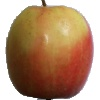

In [4]:
img

In [5]:
appleimage_names = os.listdir(url)
appleimage_names[0]

'0_100.jpg'

Wir können Bilder skalieren, um es an den Output anzupassen.
- Oder jede andere Transformation anwenden. 

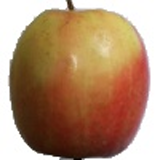

In [75]:
img_scaled = cv2.imread(url+"0_100.jpg")
res = cv2.resize(img_scaled, dsize=(160, 160), interpolation=cv2.INTER_CUBIC)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
type(res)
PIL.Image.fromarray(res)

In [77]:
# Erstelle Numpy Dataset
apple_dataset = [np.array( cv2.cvtColor(cv2.resize(cv2.imread(url+name), dsize=(160, 160), interpolation=cv2.INTER_CUBIC ),cv2.COLOR_BGR2RGB ))
                 for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

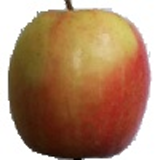

In [117]:
PIL.Image.fromarray(apple_dataset[201])

In [80]:
len(appleimage_names)

456

Das Netz wird kein perfektes Bild generieren, es reicht aus wenn das Bild ähnlich aussieht. Es geht darum, die Funktionsweise zu zeigen.

<h2>Aufbau Netz</h2>

In [81]:
image_dim = 160*160
noise_dim = 80

In [130]:
# Generator soll Bild erzeugen.
# - Üblicherweise schreibt man dazu wie groß der Output jeder Schicht ist => Verbessert Sichtbarkeit, wenn man Netz erstellt oder verändert. 
# - Durch BatchNormalization() wird das Training stabiler.
# - Optional können weitere Elemente genutzt werden. 
# Als Aktivierungsfunktion kann LeakyReLU() und ReLU() genutzt werden, achte auf Skalierung des Datasets. 
def create_generator(img_dim:int=125):
    model = tf.keras.Sequential()
    # ---- # Skaliere Noise Vektor 
    model.add(tf.keras.layers.Dense(units=5*5*256, input_shape=(img_dim, ), use_bias=False))  # x*x: Bildgröße zu Begin. Durch Operationen -> 100 x 100 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 5, 5, 256)))  # Reshape für CNN.  # TensorShape([1, 25, 25, 256])
    # ---- # 
    # Durch Strides, Filters und Padding wird Output skaliert. Aufpassen das am Ende die richtige Größe herauskommt. 
    # Danach folgt das Umkehren des Faltungsnetzes. 
    # ---- #
    # Transpose # 1
    # filters: Anzahl Filter, um Features zu erkennen. kernel_size: Größe Filter. padding: Art des Paddings, siehe Dok. 
    # Strides: Schrittweite des Filters.
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 25, 25, 256])
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=70, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 10, 10, 70])
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=60, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 20, 20, 60])
    # Transpose # 4
    model.add(tf.keras.layers.Conv2DTranspose(filters=40, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    # TensorShape([1, 40, 40, 40])
    # Transpose # 5
    model.add(tf.keras.layers.Conv2DTranspose(filters=20, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())   # TensorShape([1, 80, 80, 20])

    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Anders als bei einem ANN muss der Output nicht extra umgefort werden. 

    return model
    

Beim Konstruieren kann so z. B. der Output und die Form eingesehen und weitere Informationen ausgegeben werden.

Der Aufbau hier ist wieder recht simpel, wenn es darum geht nur eine Klasse eines Bildes zu erzeugen.

In [97]:
# Damit können wir einfach und schnell sehen was das Netz ausgibt. 
# - Für eine Schritt für Schritt konstruierung.
noise = np.random.normal(0, 1, (1, noise_dim))  
generator = create_generator(noise_dim)
img = generator(noise)
img.shape

TensorShape([1, 160, 160, 3])

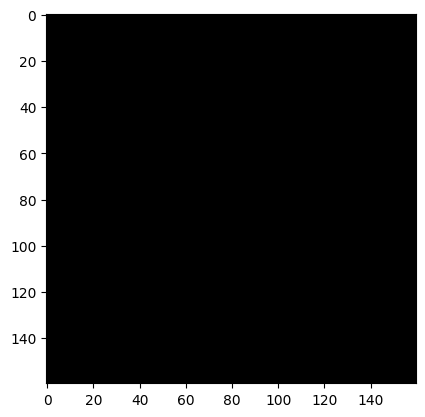

In [84]:
# Noch ist da nichts. 
plt.imshow(np.array(img[0], np.int32))

In [69]:
generator.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 6400)              512000    
                                                                 
 batch_normalization_120 (Ba  (None, 6400)             25600     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_117 (LeakyReLU)  (None, 6400)             0         
                                                                 
 reshape_25 (Reshape)        (None, 5, 5, 256)         0         
                                                                 
 conv2d_transpose_106 (Conv2  (None, 5, 5, 128)        524288    
 DTranspose)                                                     
                                                                 
 batch_normalization_121 (Ba  (None, 5, 5, 128)      

Jetzt kommt der Discriminator der beurteilen soll, ob es sich um ein Fake handelt oder nicht. <br>
Je nach Konzept, das man nutzt, kann sich der Aufbau und nutzen unterscheiden.

In [98]:
def create_discriminator(image_dim:int=160):
    model = tf.keras.Sequential()
    # --- # Einfaches CNN. 
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), input_shape=(image_dim, image_dim,3), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    return model
    

In [87]:
discriminator = create_discriminator()
discriminator.build(input_shape=(1,image_dim,image_dim,3))
discriminator.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 160, 160, 128)     9728      
                                                                 
 leaky_re_lu_133 (LeakyReLU)  (None, 160, 160, 128)    0         
                                                                 
 dropout_4 (Dropout)         (None, 160, 160, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        204864    
                                                                 
 leaky_re_lu_134 (LeakyReLU)  (None, 80, 80, 64)       0         
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 32)      

<u>Hinweis:</u><br>
Es gibt verschiedene Arten von GANs wie z. B. Wasserstein-GAN das bessere Ergebnis liefert. Hier geht es darum, sich allgemein mit GAN zu beschäftigen. In anderen Notebooks werden weitere Varianten und Details besprochen sowie deren Unterschiede und Probleme.

<h2>Training 1</h2>

Danach erstellen wir das GAN-Netzwerk und trainieren es. Es gibt einige Möglichkeiten dies zu tun. Die unteren Beispiele Zeigen einige Routinen die nach Bedarf weiter angepasst werden können.

In [131]:
# Erstelle Modelle. 
generator     = create_generator(noise_dim)
discriminator = create_discriminator()

In [132]:
# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')

discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

Während des Trainings haben wir die Option generierte Bilder zu speichern. Hier speichern wir das Bild als Array, um es später zu Ploten.

In [133]:
# Trainingsschleife # 
# - Beide Modelle werden trainiert
def train(real_images, generator, discriminator, batch_size: int = 16, epochs: int = 400, noise_dim:int=80):
    
    half_batch = int(batch_size / 2)
    # Sammle Loss für Plot.
    d_losses = []
    g_losses = []
    gen_img_array = []

    for epoch in range(epochs):
        idx        = np.random.randint(0, real_images.shape[0], half_batch)  # Ziehe Samples
        real_imgs  = real_images[idx]  # Hole Samples
        noise      = np.random.normal(0, 1, (half_batch, noise_dim))  # Erstelle Startbild- Rauschen.
        
        # Discriminator # 
        with tf.GradientTape() as d_tape:
            
            generated_images = generator(noise, training=True)  # Generiere Bild
            real_output      = discriminator(real_imgs, training=True)
            fake_output      = discriminator(generated_images, training=True)

            # Berechne Loss #
            # discriminator.train_on_batch(<>)
            loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
            loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
            d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            
        # Wende die Gradienten an.
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Generator # 
        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        with tf.GradientTape() as g_tape:
            
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)

            # Berechne Loss # 
            g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
            g_loss = tf.reduce_mean(g_loss)

        # Wende Gradienten an.
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        print(f"Epoch: {epoch + 1}/{epochs} D_loss: {d_loss.numpy()} G_loss: {g_loss.numpy()}")
        d_losses.append(d_loss)  # Hänge Loss an für den Plot. 
        g_losses.append(g_loss)
        if epoch%200==0:
            gen_img_array.append(generator.predict(noise))

    return gen_img_array, d_losses, g_losses


In [134]:
# Skaliere. 
# - Wähle eine Skalierung aus. 
numpy_images = (np.asarray(apple_dataset) - 127.5) / 127.5

In [135]:
generated_img, d_losses, g_losses = train(numpy_images, generator, discriminator, 8, 1001)

Epoch: 1/1001 D_loss: 1.4021928310394287 G_loss: 0.32145217061042786
1/1 [==============================] - 0s 143ms/step
Epoch: 2/1001 D_loss: 1.7698928117752075 G_loss: 1.8759071826934814
Epoch: 3/1001 D_loss: 0.35731959342956543 G_loss: 5.293609619140625
Epoch: 4/1001 D_loss: 0.03392202407121658 G_loss: 10.436979293823242
Epoch: 5/1001 D_loss: 0.0009974909480661154 G_loss: 14.971491813659668
Epoch: 6/1001 D_loss: 6.123162165749818e-05 G_loss: 16.789655685424805
Epoch: 7/1001 D_loss: 0.00027379902894608676 G_loss: 13.555215835571289
Epoch: 8/1001 D_loss: 0.0346296988427639 G_loss: 20.091033935546875
Epoch: 9/1001 D_loss: 7.408303737640381 G_loss: 0.0005984860472381115
Epoch: 10/1001 D_loss: 9.433095932006836 G_loss: 7.199027459137142e-05
Epoch: 11/1001 D_loss: 9.662031173706055 G_loss: 0.1324070394039154
Epoch: 12/1001 D_loss: 2.9450979232788086 G_loss: 9.07905101776123
Epoch: 13/1001 D_loss: 0.030124690383672714 G_loss: 14.65112590789795
Epoch: 14/1001 D_loss: 0.003611435182392597 G

Mit weiteren Optimierungen können die Netze besseren Output liefern.

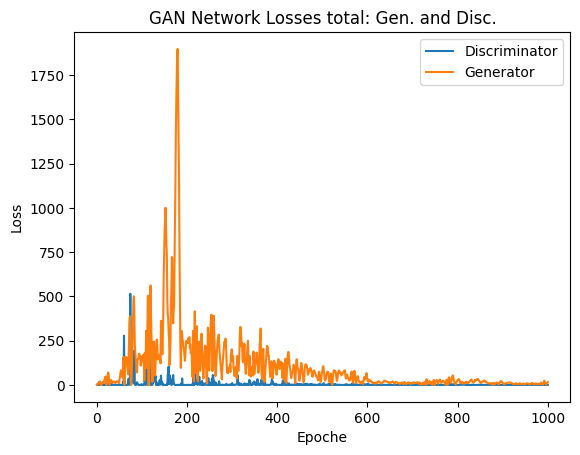

In [136]:
#plt.figure(figsize=(16, 8))
plt.title("GAN Network Losses total: Gen. and Disc.")
plt.xlabel("Epoche")
plt.ylabel("Loss")

plt.plot(range(len(d_losses)), d_losses, label="Discriminator")
plt.plot(range(len(g_losses)), g_losses, label="Generator")
plt.legend()

Um den Fortschritt sichtbar zu machen werden die Bilder die gesammelt wurden in einem Plot gezeigt. 

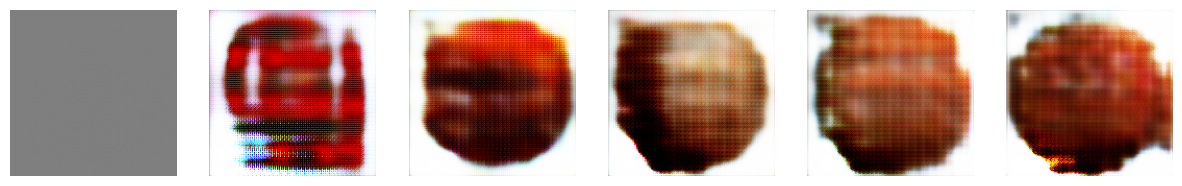

In [137]:
fig, axs = plt.subplots(1,len(generated_img), figsize=(15, 6))
axs = axs.ravel()

for i in range(len(generated_img)):
    img = generated_img[i][0]
    img  = (img * 127.5 + 127.5).astype(np.uint8)
    axs[i].set_axis_off()
    axs[i].imshow(img)

1/1 [==============================] - 0s 19ms/step


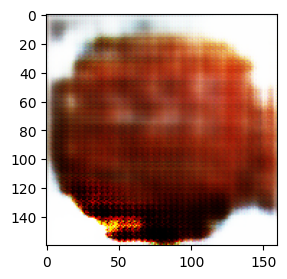

In [151]:
# Generiere ein Bild.
noise = np.random.normal(0, 1, (1, noise_dim))  
fake_img = generator.predict(noise)
generated_image = (fake_img * 127.5 + 127.5).astype(np.uint8)
plt.figure(figsize=(3,3))
plt.imshow(generated_image[0])

<h2>Training 2 - Nutze TensorFlow Dataset</h2>

Hier wollen wir das Training etwas anders gestalten. 

Siehe:
> Writing a training loop from scratch <br>
> https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch [Letzter Zugriff: 24.07.2024]

Erstelle ein TF Dataset.

In [163]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Red_Delicious/"
appleimage_names = os.listdir(url)

apple_dataset = [np.array( cv2.cvtColor(cv2.resize(cv2.imread(url+name), dsize=(160, 160), interpolation=cv2.INTER_CUBIC ),cv2.COLOR_BGR2RGB ))
                 for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

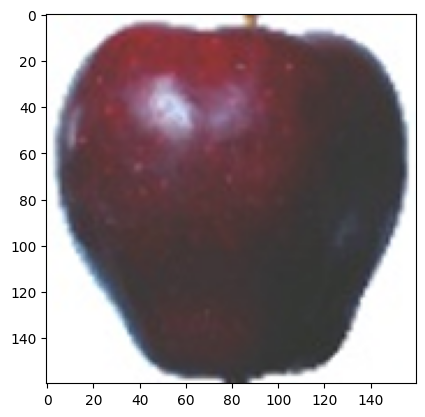

In [164]:
plt.imshow(apple_dataset[4])

In [165]:
apple_dataset = (np.asarray(apple_dataset) - 127.5) / 127.5

In [166]:
len(apple_dataset)

490

In [167]:
# Erstelle TF Dataset.
batch_size = 32

apple_dataset_tf = tf.data.Dataset.from_tensor_slices(apple_dataset).shuffle(buffer_size=1024).batch(batch_size//2)
apple_dataset_tf

<BatchDataset element_spec=TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float64, name=None)>

In [171]:
len(apple_dataset_tf) * batch_size//2

496

In [172]:
# Erstelle Modelle. 
generator     = create_generator(noise_dim)
discriminator = create_discriminator()

# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

In [174]:
# Trainingsschleife # 
# - Beide Modelle werden trainiert
def train(real_images, generator, discriminator, batch_size=32, epochs=4, noise_dim:int=80):
    half_batch = int(batch_size / 2)
    
    #
    # Oder erstelle / transformiere Dataset hier. # 
    #
    
    for epoch in range(epochs):
        print(f"Starte Epoche {epoch+1}")
        for step, real_imgs in enumerate(real_images):
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            
            # Discriminator #
            with tf.GradientTape() as d_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(real_imgs, training=True)
                fake_output = discriminator(generated_images, training=True)
                # Berechne Loss #
                loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
                loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            # Wende Gradienten an.
            d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

            # Generator #
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            with tf.GradientTape() as g_tape:
                
                generated_images = generator(noise, training=True)
                fake_output = discriminator(generated_images, training=True)
                # Calculate loss
                g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                g_loss = tf.reduce_mean(g_loss)
            # Wende Gradienten an.
            g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
            generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

            if step % 30 == 0:
                print(f"Step: {step}, D_loss: {d_loss.numpy()}, G_loss: {g_loss.numpy()}, Batches bisher: {(step + 1) * batch_size}")


In [175]:
train(apple_dataset_tf, generator, discriminator, 8, 4)

Starte Epoche 1
Step: 0, D_loss: 1.4294328689575195, G_loss: 0.48175182938575745, Batches bisher: 8
Step: 30, D_loss: 4.288326638235418e-12, G_loss: 54.05802917480469, Batches bisher: 248
Starte Epoche 2
Step: 0, D_loss: 1.5333580687282463e-16, G_loss: 63.56257629394531, Batches bisher: 8
Step: 30, D_loss: 0.0, G_loss: 430.4832458496094, Batches bisher: 248
Starte Epoche 3
Step: 0, D_loss: 28.583654403686523, G_loss: 676.3743286132812, Batches bisher: 8
Step: 30, D_loss: 2.353519070784155e-31, G_loss: 395.86328125, Batches bisher: 248
Starte Epoche 4
Step: 0, D_loss: 9.22044563293457, G_loss: 412.6726989746094, Batches bisher: 8
Step: 30, D_loss: 1.0363261767583906e-24, G_loss: 273.8966369628906, Batches bisher: 248


<h1>Multi-Class CNN Image Generation.: Apfel und Mango</h1>

Um mehrere Klassen abzubilden, könnte man wieder Embeddings nutzen.

In [187]:
def get_generator(noise_dim=125):
    noise_input = tf.keras.Input(shape=(noise_dim,))  
    label_input = tf.keras.Input(shape=(1,), dtype='int32') 
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=noise_dim)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    model_input     = tf.keras.layers.multiply([noise_input, label_embedding])  # Multipliziere, damit haben die Labels direkten Einfluss.

    x = tf.keras.layers.Dense(units=5*5*256, input_shape=(noise_dim, ), use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape(( 5, 5, 256))(x)
    # ---- # 
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5),  padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=70, kernel_size=(5,5),  strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=60, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=40, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=20, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], output)

In [188]:
# Teste, ob Aufbau funktioniert. 
generator = get_generator(noise_dim)
noise     = np.random.normal(0, 1, (1, noise_dim))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])
fake_images.shape

1/1 [==============================] - 0s 145ms/step


(1, 160, 160, 3)

In [189]:
def get_discriminator(image_dim:int=160):
    image_input = tf.keras.Input(shape=(image_dim, image_dim, 3))  # 
    label_input = tf.keras.Input(shape=(1,), dtype='int32')  
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=image_dim*image_dim*3)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    label_embedding = tf.keras.layers.Reshape(( image_dim, image_dim, 3))(label_embedding) 
    # Durch Konkatenation: Passt Bild auch zum Label? 
    model_input = tf.keras.layers.concatenate([image_input, label_embedding])   

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(1,1), input_shape=(image_dim,image_dim,3), padding='same')(model_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    return tf.keras.Model([image_input, label_input], output)

In [193]:
# Teste, ob Aufbau funktioniert. 
discriminator = get_discriminator()

generator = get_generator(noise_dim)
noise     = np.random.normal(0, 1, (1, noise_dim))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])
discriminator.predict([fake_images, fake_labels])

1/1 [==============================] - 0s 78ms/step


array([[0.49975303]], dtype=float32)

<h2>Dataset</h2>

In [194]:
fruit_labels   = ['Apfel', 'Mango']
encoded_labels = {'Apfel':0, 'Mango': 1}
klass_dirs     = {'Apfel': 'Apple_Red_Delicious/', 'Mango': 'Mango/'}
url            = "data/datasets/archive/fruits-360_dataset/fruits-360/Training/"

In [195]:
#fruit_img_data = [np.asarray(PIL.Image.open(url+klass_dirs[fruitname]+imgname, mode='r'))  for fruitname in fruit_labels for imgname in os.listdir(url+klass_dirs[fruitname])]
fruit_img_data = [np.array( cv2.cvtColor(cv2.resize(cv2.imread(url+klass_dirs[fruitname]+imgname), dsize=(160, 160), interpolation=cv2.INTER_CUBIC ),cv2.COLOR_BGR2RGB ))
                  for fruitname in fruit_labels for imgname in os.listdir(url+klass_dirs[fruitname])]

In [196]:
fruit_img_labels = []
fruit_img_labels.extend(np.array([0] * len(os.listdir(url+klass_dirs['Apfel']))))
fruit_img_labels.extend(np.array([1] * len(os.listdir(url+klass_dirs['Mango']))))

In [197]:
len(fruit_img_data) == len(fruit_img_labels)

True

In [198]:
fruit_img_data   = np.array(fruit_img_data)
fruit_img_labels = np.array(fruit_img_labels)

In [199]:
fruit_img_data_scaled =  (fruit_img_data -127.5) / 127.5

In [200]:
fruit_img_data_scaled.shape

(980, 160, 160, 3)

<h2>Erstelle Model und Training</h2>

In [202]:
batch_size=8
dataset_2classes = tf.data.Dataset.from_tensor_slices((fruit_img_data_scaled, fruit_img_labels)).shuffle(buffer_size=1024).batch(batch_size//2)

In [206]:
# Trianingsschleife
# 
def train(dataset, generator, discriminator, batch_size=16, epochs=400, noise_dim=125):
    
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        print(f"Starte Epoche {epoch}")
        for step, (real_imgs, real_labels) in enumerate(dataset):
            
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
           
            # Discriminator #
            with tf.GradientTape() as d_tape:
                fake_labels = np.random.randint(0, 2, half_batch)  # Change (0, 2, half_batch)
                generated_images = generator([noise, fake_labels], training=True)
                real_output = discriminator([real_imgs, real_labels], training=True)
                fake_output = discriminator([generated_images, fake_labels], training=True)

                # Berechne Loss. 
                loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
                loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            
            # Wende Gradienten an. 
            d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
            
            # Generator #
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            fake_labels = np.random.randint(0, 2, (half_batch, 1))
            with tf.GradientTape() as g_tape:
                generated_images = generator([noise, fake_labels], training=True)
                fake_output = discriminator([generated_images, fake_labels], training=True)
                # Generator Loss
                g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                g_loss = tf.reduce_mean(g_loss)
            # Wende Gradienten an.
            g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
            generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
            
            if step % 30 == 0:
                print(f"Step: {step}, D_loss: {d_loss.numpy()}, G_loss: {g_loss.numpy()}, Batches bisher: {(step + 1) * batch_size}")


In [204]:
generator     = get_generator(noise_dim=80)
discriminator = get_discriminator()

generator.optimizer = tf.keras.optimizers.Adam()
discriminator.optimizer = tf.keras.optimizers.Adam()

In [207]:
train(dataset_2classes, generator, discriminator, batch_size, epochs=10, noise_dim=80)

Starte Epoche 0
Step: 0, D_loss: 1.3439109325408936, G_loss: 0.8304463624954224, Batches bisher: 8
Step: 30, D_loss: 1.4825479984283447, G_loss: 0.008498931303620338, Batches bisher: 248
Step: 60, D_loss: 3.791079521179199, G_loss: 0.04608643800020218, Batches bisher: 488
Step: 90, D_loss: 1.1580379009246826, G_loss: 6.123318195343018, Batches bisher: 728
Step: 120, D_loss: 0.14197388291358948, G_loss: 10.717183113098145, Batches bisher: 968
Step: 150, D_loss: 1.4005627632141113, G_loss: 0.5496523380279541, Batches bisher: 1208
Step: 180, D_loss: 0.4606354236602783, G_loss: 4.361016273498535, Batches bisher: 1448
Step: 210, D_loss: 0.34155312180519104, G_loss: 6.2734694480896, Batches bisher: 1688
Step: 240, D_loss: 0.9265956878662109, G_loss: 3.3264265060424805, Batches bisher: 1928
Starte Epoche 1
Step: 0, D_loss: 0.05701722204685211, G_loss: 4.984302043914795, Batches bisher: 8
Step: 30, D_loss: 1.0855664014816284, G_loss: 6.138858795166016, Batches bisher: 248
Step: 60, D_loss: 0.0

Jetzt können wir zwei verschiedene Objekte generieren. <br>
In späteren Notebooks werden weitere Details behandelt, um bessere Ergebnisse zu erzielen.

1/1 [==============================] - 0s 22ms/step


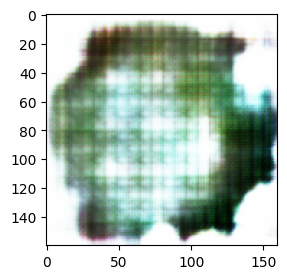

In [219]:
noise = np.random.normal(0, 1, (1, 80))
img = generator.predict([noise, np.array([1])])  # Wähle Klasse

img  = (img * 127.5 + 127.5).astype(np.uint8)
plt.figure(figsize=(3,3))
plt.imshow(img[0])